# Description

This notebook calculates the Bayesian posterior distribution of the Poisson event occurence rate, given the number events observed ```n_events``` during a test of ```test_duration```, using a uniform prior distribution.

This notebook produces a graph that tells you how much belief you can put into any of the possible event occurence rates between 0 (always fails) and infinity after having done a test of ```test_duration``` during which ```n_events``` events were observed. This result depends on a so-called prior distribution that models your belief in different possible event occurrence rates before the test. By default we choose a uniform prior, since this does not skew the results (the maximum belief will be for exactly the success rate of your test run).

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated degree of belief is __NOT__ conservative. It depends on the chosen prior and can be both too high and too low.

# Parameters

In [1]:
test_duration = 10
n_events = 1

assert isinstance(test_duration, (int, float)) and test_duration > 0
assert isinstance(n_events, int) and n_events >= 0

# Evaluation

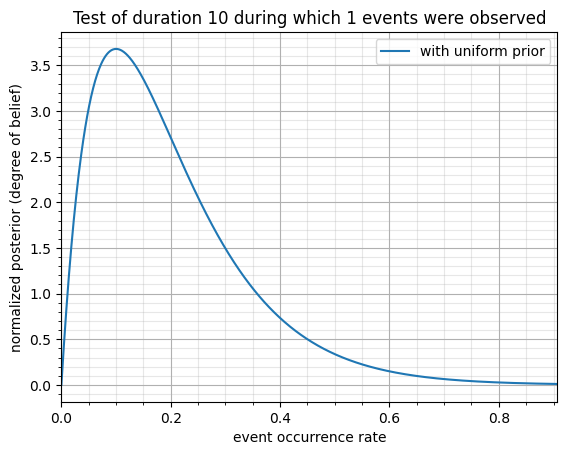

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_poisson_p(r_event, test_duration, n_events, prior):
    return mp.power(mp.mpf(r_event*test_duration), n_events) / mp.fac(n_events) * mp.exp(-r_event*test_duration) * prior(r_event, test_duration)

posterior_prob_poisson_p_vectorized = np.vectorize(posterior_prob_poisson_p)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large test_duration
def integrate_posterior_prob_poisson_p_norm(test_duration, n_events, prior, bounds):
    mean = (n_events+1) / test_duration
    std_dev = (n_events+1)**0.5 / test_duration
    prescale = 1/posterior_prob_poisson_p(mean, test_duration, n_events, prior)
    prior_prescaled = lambda r, duration: prior(r, duration) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(test_duration, n_events, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_p, max(mean+3*std_dev, bounds[0]), bounds[1], args=(test_duration, n_events, prior_prescaled))[0]
        
    return norm / prescale

r_plotmax = (n_events+1)/test_duration + 5*(n_events+1)**0.5/test_duration #mean+5*std_dev
r = np.linspace(0, r_plotmax, 1001)

prior = lambda rate, duration: 1
posterior_probs = posterior_prob_poisson_p_vectorized(r, test_duration, n_events, prior) / integrate_posterior_prob_poisson_p_norm(test_duration, n_events, prior, [0, np.inf])
plt.plot(r, posterior_probs, label='with uniform prior')

# r = r[r > 0] #Exclude singularity at 0 of Jeffrey's prior
# prior = lambda rate, duration: (rate*duration)**-0.5
# prior_vectorized = np.vectorize(prior)
# posterior_probs = posterior_prob_poisson_p_vectorized(r, test_duration, n_events, prior) / integrate_posterior_prob_poisson_p_norm(test_duration, n_events, prior, [0, np.inf])
# plt.plot(r, posterior_probs, label='with Jeffrey\'s prior')
# plt.plot(r, prior_vectorized(r, test_duration), label='Jeffrey\'s prior')

plt.gca().set_title('Test of duration {} during which {} events were observed'.format(test_duration, n_events))
plt.gca().set_xlabel('event occurrence rate')
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend()

plt.gca().set_xlim([0, r_plotmax]); #change plot range here